In [1]:
#### Create Plots based on OSCAR xml files ####
# analysis of specific variables

# used python version 3.10.6

In [3]:
import xml.etree.ElementTree as ET
import urllib.request
import csv
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen
import json
import re
import os
import pandas as pd

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas as pd
import matplotlib.lines as mlines

In [4]:
#### Get WIGOS IDs for all stations catalogued in a country ####

country = "KEN"

# API: all stations as json
all_stations_KEN_url = "https://oscar.wmo.int/surface/rest/api/search/station?territoryName="+country


response = urlopen(all_stations_KEN_url)
data_json = json.loads(response.read())
stations = data_json["stationSearchResults"]

wigosIds = []

for station in data_json["stationSearchResults"]:
    # print(station["wigosId"])
    wigosId = str(station["wigosId"])
    wigosIds.append(wigosId)

print(wigosIds)

['0-404-300-301570787AS00074', '0-404-300-402261127AS63663', '0-404-300-271440721AS00049', '0-404-300-281480740AS00057', '0-404-0-63707', '0-404-300-392191090AS63662', '0-404-0-63721', '0-404-300-040200100AS00113', '0-404-300-040200098AS00112', '0-404-300-301620807AS00073', '0-404-300-301580790AS00071', '0-404-300-402251125AS00038', '0-404-300-402281141AS00036', '0-404-300-402291146AS00033', '0-404-300-392181085AS63660', '0-404-300-361950974AS00015', '0-20000-0-63741', '0-404-300-472781389AS63747', '0-404-300-100470235AS00114', '0-404-300-372081037AS00024', '0-404-300-372000999AS00025', '0-404-300-372031019AS00022', '0-404-300-372101048AS00026', '0-20000-0-63688', '0-404-300-63686', '0-20000-0-63720', '0-404-0-63719', '0-404-300-341870932AS00005', '0-404-300-341840918A00001', '0-404-300-050210101AS00090', '0-404-0-63670', '0-20000-0-63723', '0-404-300-190950473AS00101', '0-404-300-060230111AS00047', '0-404-300-190950476AS00099', '0-404-300-070320150AS00107', '0-404-300-341840918AS00001

In [71]:
import xml.etree.ElementTree as ET
tree = ET.parse('/home/sdanioth/Documents/git/OSCAR_analysis/NRB_xml.xml')
root = tree.getroot()
print(root)

<Element '{http://www.openarchives.org/OAI/2.0/}OAI-PMH' at 0x7f552ee3a2a0>


In [101]:
import xml.etree.ElementTree as ET

tree = ET.parse('/home/sdanioth/Documents/git/OSCAR_analysis/NRB_xml.xml')
root = tree.getroot()

# Top-level elements
root.findall(".")

# All 'neighbor' grand-children of 'country' children of the top-level
# elements
root.findall("./GetRecord")

# # Nodes with name='Singapore' that have a 'year' child
# root.findall(".//year/..[@name='Singapore']")

# # 'year' nodes that are children of nodes with name='Singapore'
# root.findall(".//*[@name='Singapore']/year")

# # All 'neighbor' nodes that are the second child of their parent
# root.findall(".//neighbor[2]")

[]

In [113]:
from xml.etree import ElementTree, ElementInclude

tree = ElementTree.parse('/home/sdanioth/Documents/git/OSCAR_analysis/NRB_xml.xml')
root = tree.getroot()

# ElementInclude.include(root)

print(root)


element = root.find('observedProperty')

print(element)

<Element '{http://www.openarchives.org/OAI/2.0/}OAI-PMH' at 0x7f552ef85cb0>
None


In [241]:
from urllib.request import urlopen
from bs4 import BeautifulSoup


url = "https://oscar.wmo.int/oai/provider?verb=GetRecord&metadataPrefix=wmdr&identifier=%20" + "0-20008-0-NRB"
xml = urlopen(url).read()
soup = BeautifulSoup(xml, 'xml')

# Retrieve all of the anchor tags
tags = soup('OAI-PMH')
print(tags)



[<OAI-PMH xmlns="http://www.openarchives.org/OAI/2.0/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.openarchives.org/OAI/2.0/  http://www.openarchives.org/OAI/2.0/OAI-PMH.xsd">
<responseDate>2023-10-19T12:50:57Z</responseDate>
<request identifier=" 0-20008-0-NRB" metadataPrefix="wmdr" verb="GetRecord">https://oscar.wmo.int:443/oai/provider</request>
<GetRecord>
<record>
<header>
<identifier>0-20008-0-NRB</identifier>
<datestamp>2023-10-04T12:43:05Z</datestamp>
<setSpec>landFixed</setSpec>
</header>
<metadata>
<!--Invalid xml:javax.xml.bind.UnmarshalException
 - with linked exception:
[org.xml.sax.SAXParseException; lineNumber: 696; columnNumber: 46; cvc-datatype-valid.1.2.1: '(null)' is not a valid value for 'NCName'.]-->
<!--The element wmdr:internationalExchange has been exported as 'false' (real value is 'null'). Before resubmitting this XML please remove this comment and review the value of wmdr:internationalExchange under wmdr:DataGeneration

In [242]:
%%capture cap --no-stderr
print(tags)

In [243]:
id = "0-20008-0-NRB"

with open(os.getcwd()+"/Files/File_"+id+".txt", 'w') as f:
    f.write(cap.stdout)

In [246]:
var = "263" 

numbers = []

with open('/home/sdanioth/Documents/git/OSCAR_analysis/Files/File_'+id+'.txt') as myFile:
    for num, line in enumerate(myFile, 1):
        if var in line:
            numbers.append(num)

print(numbers)

[643, 682, 735, 824, 875, 962]


In [247]:
f=open('/home/sdanioth/Documents/git/OSCAR_analysis/Files/File_'+id+'.txt')
lines=f.readlines()

obs = "observedProperty"
numbers_obs = []

for n in numbers:
    if obs in lines[n-1]:
        numbers_obs.append(n)

print(numbers_obs)

[682, 824, 962]


In [284]:
### read 20 lines before "observedProperty" line to get "beginPosition" (& "endPosition")

n = 2816
all_dates = []

for n in numbers_obs:
    start = "beginPosition"
    end = "endPosition"
    line_numbers = range(n-20,n)

    f=open('/home/sdanioth/Documents/git/OSCAR_analysis/Files/File_'+id+'.txt')
    lines=f.readlines()
    positions = []

    for n in line_numbers:
        if start in lines[n]:
            # positions.append(lines[n])
            beginning = re.findall(r'\d{4}-\d{2}-\d{2}',lines[n])
            pd.to_datetime(beginning, format='%Y-%m-%d')
            positions.append(beginning[0])
        elif end in lines[n]:
            ending = re.findall(r'\d{4}-\d{2}-\d{2}',lines[n])
            if ending:
                pd.to_datetime(ending, format='%Y-%m-%d')
                positions.append(ending[0])
            else:
                positions.append(pd.Timestamp.today().strftime("%Y-%m-%d"))

    all_dates.append(positions)

print(all_dates)

[['2019-03-20', '2023-10-19'], ['2005-05-01', '2012-12-31'], ['1984-04-19', '1999-12-31']]


In [333]:
df = pd.DataFrame(all_dates)
df.columns=["beginPosition", "endPosition"]
df["station"] = id
df["variable"] = var
print(df)


  beginPosition endPosition        station  variable
0    2019-03-20  2023-10-19  0-20008-0-NRB       263
1    2005-05-01  2012-12-31  0-20008-0-NRB       263
2    1984-04-19  1999-12-31  0-20008-0-NRB       263


In [323]:
# combine 3 dictionaries (Atmosphere, Ocean & Terrestrial)

with open(os.getcwd()+'/WMDR_dictionaries/'+"ObservedVariableAtmosphere_WMDR"+'_dictionary.json') as f:
    dictionary = json.loads(f.read())


with open(os.getcwd()+'/WMDR_dictionaries/'+"ObservedVariableOcean_WMDR"+'_dictionary.json') as f:
    dictionary_Ocean = json.loads(f.read())   

dictionary.update(dictionary_Ocean)

with open(os.getcwd()+'/WMDR_dictionaries/'+"ObservedVariableTerrestrial_WMDR"+'_dictionary.json') as f:
    dictionary_Terrestrial = json.loads(f.read())

dictionary.update(dictionary_Terrestrial)


In [329]:
print(df)
print(dictionary)

  beginPosition endPosition        station  variable
0    2019-03-20  2023-10-19  0-20008-0-NRB       263
1    2005-05-01  2012-12-31  0-20008-0-NRB       263
2    1984-04-19  1999-12-31  0-20008-0-NRB       263
{'label': 'notation', 'Aerological soundings': '37', 'Atmospheric density': '39', 'Integrated air samples': '44', 'Special phenomena': '56', 'State of ground': '57', 'Cloud amount': '179', 'Cloud cover': '180', 'Cloud drop effective radius': '181', 'Cloud hydrometeor concentration': '182', 'Effective radius of cloud hydrometeors': '183', 'Melting layer depth in clouds': '186', 'PSC occurrence': '188', 'CH4 (methane)': '192', 'CH4 (methane, C-13)': '193', 'CO2 (carbon dioxide)': '194', 'CO2 (carbon dioxide, C-13)': '195', 'CO2 [O-18]': '196', 'N2O (nitrous oxide)': '201', 'SF6 (sulfur hexafluoride)': '203', 'SO2F2 (sulfuryl fluoride)': '204', 'H2 (hydrogen molecule)': '205', 'H2O (as a chemical species)': '206', 'HDO (as a chemical species)': '207', 'Amount of precipitation': '2

In [336]:
variables = df["variable"]


df["variables_names"] = [(list(dictionary.keys())[list(dictionary.values()).index(str(vari))]) for vari in variables]
print(df)

  beginPosition endPosition        station  variable     variables_names
0    2019-03-20  2023-10-19  0-20008-0-NRB       263  Total column ozone
1    2005-05-01  2012-12-31  0-20008-0-NRB       263  Total column ozone
2    1984-04-19  1999-12-31  0-20008-0-NRB       263  Total column ozone


In [340]:
df["variables_names"][0]

'Total column ozone'

Text(0.5, 1.0, 'Total column ozone (263)')

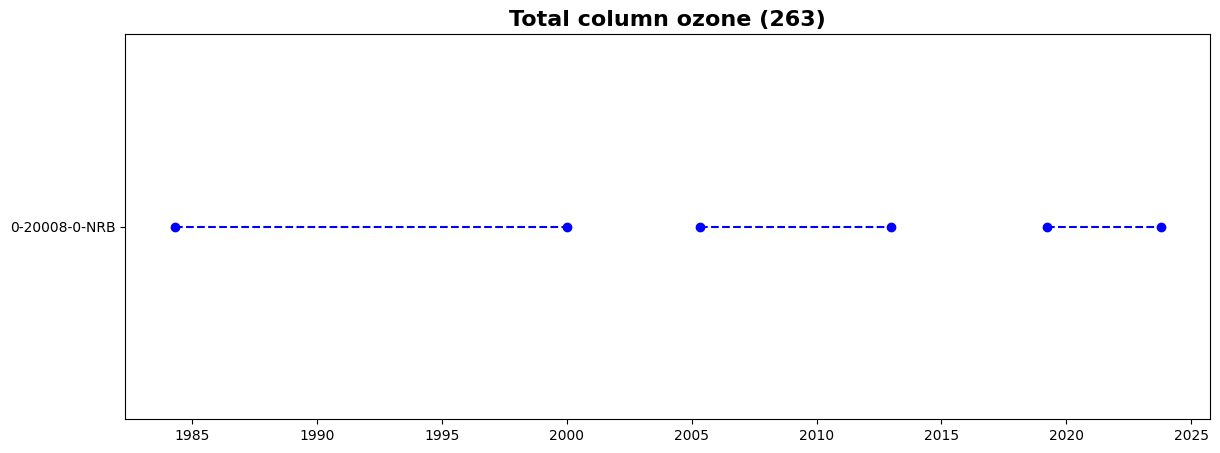

In [344]:
plt.style.use('default')
fig, axes = plt.subplots(1,1, figsize=(14,5))


x_values = [pd.to_datetime(df["beginPosition"]), pd.to_datetime(df["endPosition"])]
# print(x_values)
plt.plot(x_values, [1,1], 'bo', linestyle="--")

plt.yticks([1],[id])

# plt.legend()
plt.title(df["variables_names"][0]+ " ("+str(var)+")", fontsize=16, fontweight="bold")